In [8]:
%%capture
!pip install -U sentence-transformers

In [9]:
%%capture
!pip install pymorphy2

Напишем сами модели.
1. Модель трансформер + косинусное расстояние
2. Модель косинусное расстояние

In [10]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import re
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer


class TransferModel():
    def __init__(self):
        self.df = pd.read_excel('augmented_sample.xlsx')
        self.model = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1')
        self.sample_encoded = self.df['вопрос'].apply(lambda x: self.model.encode(x))
        self.morph = pymorphy2.MorphAnalyzer()
        self.dct = {'мат': 'материальная',
                    'студак': 'студенческий билет',
                    'вышка' : 'высшая школа экономики',
                    'академ' : 'академический отпуск',
                    'труба' : 'телефон',
                    'учебк' : 'учебный офис',
                    }

    def preprocessing(self, message):
        russian_terms =  re.findall(r'[а-яА-Яё]+', message)
        normalized_terms = list(map(lambda x: self.morph.parse(x)[0].normal_form, russian_terms))
        return ' '.join(normalized_terms)
    
    def slang_filter(self, question):
        mas = []
        for el in question.split():
            temp = self.preprocessing(el)
            if temp in self.dct:
                temp = self.dct[temp]
                mas.append(temp)
            elif temp[:-1] in self.dct:
                temp = self.dct[temp[:-1]]
                mas.append(temp)
            else:
                mas.append(el)
        return " ".join(mas)


    def get_best_three(self, question, n=3):
        question = self.slang_filter(question)
        vect_quest = self.model.encode(question)
        cosine_similarities = np.array(util.dot_score(vect_quest, self.sample_encoded)[0])
        indices = (-cosine_similarities).argsort()[:n]
        coefs = np.abs(np.sort(-cosine_similarities)[:n])
        if coefs[0] < 0.7:
            return None
        return self.df.iloc[list(indices), :].values

In [11]:
class CosModel():
    def __init__(self):
        self.df = pd.read_excel('augmented_sample.xlsx')
        self.morph = pymorphy2.MorphAnalyzer()
        self.count = CountVectorizer()
        self.sample_transformed = self.count.fit_transform(self.df['вопрос'])
        with open('stop_words.txt','rb') as inFile:
           self.stop_list = set(inFile.read().split())
    
    def preprocessing(self, message):
        russian_terms =  re.findall(r'[а-яА-Яё]+', message)
        normalized_terms = list(map(lambda x: self.morph.parse(x)[0].normal_form, russian_terms))
        return ' '.join([term for term in normalized_terms if term not in self.stop_list])
    
    def get_best_three(self, question, n=3):
        vect_quest = self.count.transform([self.preprocessing(question)])
        cosine_similarities = cosine_similarity(vect_quest, self.sample_transformed).flatten()
        indices = (-cosine_similarities).argsort()[:n]
        return self.df.iloc[list(indices), :].values

А теперь проведем 2 теста
1. на тренировочных данных
2. на тестовой выборке

In [12]:
answers_trans = TransferModel()
answers_cos = CosModel()
test = pd.read_excel('testing.xlsx')
train = pd.read_excel('augmented_sample.xlsx')

In [13]:
def my_accuracy(func):
    total = test.shape[0]
    correct = 0
    for i, row in test.iterrows():
        ans = func(row[0])
        if ans is None:
            if row[1] is None:
                correct += 1
            continue
        mas = [elem[0] for elem in ans]
        if row[1] in mas:
            correct += 1
    return correct, correct / total
print(f"точность модели трансформера: {my_accuracy(answers_trans.get_best_three)[1]}")
print(f"точности косинусной модели: {my_accuracy(answers_cos.get_best_three)[1]}")

точность модели трансформера: 0.75
точности косинусной модели: 0.53125


In [14]:
def my_train_accuracy(func):
    total = train.shape[0]
    correct = 0
    for i, row in train.iterrows():
        ans = func(row[0])
        if ans is None:
            continue
        mas = [elem[0] for elem in ans]
        if row[0] in mas:
            correct += 1
    return correct, correct / total

print(f"точность модели трансформера: {my_train_accuracy(answers_trans.get_best_three)[1]}")
print(f"точности косинусной модели: {my_train_accuracy(answers_cos.get_best_three)[1]}")

точность модели трансформера: 1.0
точности косинусной модели: 0.8728813559322034


Легко заметить, что качество предложенной модели увеличилось

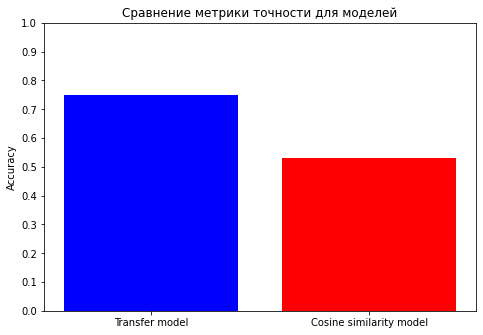

In [15]:
import matplotlib.pyplot as plt
new_model = my_accuracy(answers_trans.get_best_three)[1]
old_model = my_accuracy(answers_cos.get_best_three)[1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar('Transfer model', new_model, color='b')
ax.bar('Cosine similarity model', old_model, color='r')
ax.set_ylabel('Accuracy')
ax.set_title('Сравнение метрики точности для моделей')
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.show()

А теперь посмотрим, каких результатов добьются другие модели, которые также рассматривались.

In [16]:
class TestModel():
    def __init__(self, name):
        self.name = name
        self.df = pd.read_excel('augmented_sample.xlsx')
        self.model = SentenceTransformer(name)
        self.sample_encoded = self.df['вопрос'].apply(lambda x: self.model.encode(x))
        self.morph = pymorphy2.MorphAnalyzer()
        self.dct = {'мат': 'материальная',
                    'студак': 'студенческий билет',
                    'вышка' : 'высшая школа экономики',
                    'академ' : 'академический отпуск',
                    'труба' : 'телефон',
                    'учебк' : 'учебный офис',
                    }

    def preprocessing(self, message):
        russian_terms =  re.findall(r'[а-яА-Яё]+', message)
        normalized_terms = list(map(lambda x: self.morph.parse(x)[0].normal_form, russian_terms))
        return ' '.join(normalized_terms)
    
    def slang_filter(self, question):
        mas = []
        for el in question.split():
            temp = self.preprocessing(el)
            if temp in self.dct:
                temp = self.dct[temp]
                mas.append(temp)
            elif temp[:-1] in self.dct:
                temp = self.dct[temp[:-1]]
                mas.append(temp)
            else:
                mas.append(el)
        return " ".join(mas)


    def get_best_three(self, question, n=3):
        question = self.slang_filter(question)
        vect_quest = self.model.encode(question)
        cosine_similarities = np.array(util.dot_score(vect_quest, self.sample_encoded)[0])
        indices = (-cosine_similarities).argsort()[:n]
        coefs = np.abs(np.sort(-cosine_similarities)[:n])
        return [self.df.iloc[list(indices), :].values, coefs]

In [17]:
pre_trained = ['sentence-transformers/multi-qa-MiniLM-L6-cos-v1',
               'DeepPavlov/rubert-base-cased-sentence',
               'cointegrated/rubert-tiny',
               'bert-base-multilingual-cased',
               'sentence-transformers/LaBSE',
               ]
results = []
def my_new_accuracy(func):
    total = test.shape[0]
    correct = 0
    for i, row in test.iterrows():
        ans = func(row[0])
        if ans is None:
            continue
        mas = [elem[0] for elem in ans[0]]
        if row[1] in mas:
            correct += 1
    return correct, correct / total


for name in pre_trained:
    model = TestModel(name)
    res = my_new_accuracy(model.get_best_three)
    results.append([name, res])

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/cointegrated_rubert-tiny were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /root/.cache/torch/sentence_transfo

In [18]:
for element in results:
    print(f"{element[0]} accuracy: {element[1][1]}")

sentence-transformers/multi-qa-MiniLM-L6-cos-v1 accuracy: 0.75
DeepPavlov/rubert-base-cased-sentence accuracy: 0.6875
cointegrated/rubert-tiny accuracy: 0.6875
bert-base-multilingual-cased accuracy: 0.65625
sentence-transformers/LaBSE accuracy: 0.78125


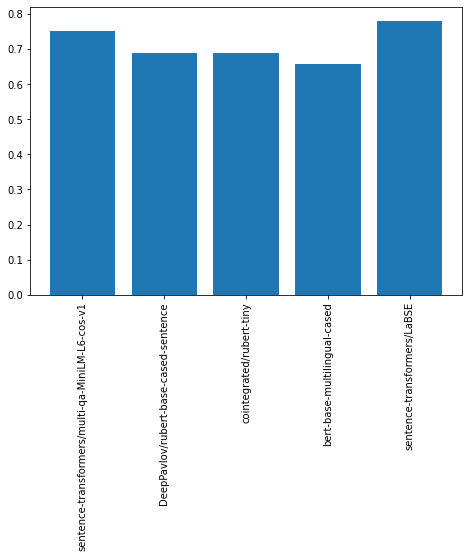

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = pre_trained
students = [i[1][1] for i in results]
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.bar(langs, students)
ax.tick_params(axis='x', labelrotation = 90)
plt.show()